In [ ]:
import os
import numpy as np
import d3rlpy
from pathlib import Path
import csv

import matplotlib.pyplot as plt
import json

# Set the base directory for d3rlpy logs
base_dir = "d3rlpy_logs"
testEpisode = "../data/episFormula/test"

#reads all the episodes in a particular folder and reutns them in a array consisting of arrays with tuples
def read_Episodes(baseFolder):
    episodes = []
    for filename in sorted(os.listdir(baseFolder)):
        filePath = os.path.join(baseFolder, filename)
        episode = []
        with open(filePath, "r", newline="") as file:
            reader = csv.reader(file)
            for row in reader:
                observation = [float(epi) for epi in row]
                episode.append(observation)
            episodes.append(episode)        
    return episodes

# Function to load models from a training directory (max 10, evenly distributed)
def load_models_from_training(training_dir):
    models = []
    model_files = sorted([f for f in os.listdir(training_dir) if f.endswith('.d3')])
    
    # Select maximum 10 models, evenly distributed, always including the last one
    if len(model_files) > 10:
        # Always include the last (newest) model
        selected_indices = []
        
        # Calculate step size for the first 9 models
        step = (len(model_files) - 1) / 9
        selected_indices = [int(i * step) for i in range(9)]
        
        # Always add the last model
        selected_indices.append(len(model_files) - 1)
        
        # Remove duplicates and sort
        selected_indices = sorted(list(set(selected_indices)))
        
        model_files = [model_files[i] for i in selected_indices]
        print(f"Selected {len(model_files)} models out of {len(sorted([f for f in os.listdir(training_dir) if f.endswith('.d3')]))} available models (including the latest)")
    
    for model_file in model_files:
        model_path = os.path.join(training_dir, model_file)
        try:
            # Load the model (adjust algorithm type as needed)
            model = d3rlpy.load_learnable(model_path)
            models.append((model_file, model))
        except Exception as e:
            print(f"Error loading {model_file}: {e}")
    
    return models

# Function to create episode visualization for all models
def create_episode_visualization(algorithm_name, models, epiPath, batch_size=None, n_steps_per_episode=None):
    plt.figure(figsize=(12, 8))
    
    # Create a simple test episode (replace with your actual environment)
    # This is a placeholder - you'll need to adapt this to your specific environment    
    epis = read_Episodes(epiPath)

    observations = []
    actions = []

    epi = epis[2]  # Using the first episode for visualization
    for observation in epi:
        observations.append(observation[:-2])
        actions.append(observation[-2:-1])

    observations=np.array(observations)
    actions=np.array(actions)
    
    # Plot the ideal actions first as thick reference line
    step_numbers = list(range(len(actions)))
    plt.plot(step_numbers, actions.flatten(), 
             label='Ideal Actions (from Episode)', 
             linewidth=3, 
             color='black', 
             alpha=0.8)
    
    for i, (model_name, model) in enumerate(models):
        try:
            # Get predictions from the model
            model_actions = []
            values = []
            # Method 1: Try batch prediction first (more efficient)
            try:
                # If observations already has correct shape (x, 7), try batch prediction
                batch_actions = model.predict(observations)
                model_actions = batch_actions.flatten().tolist() if batch_actions.ndim > 1 else batch_actions.tolist()
                
                # Try batch value prediction
                try:
                    batch_values = model.predict_value(observations)
                    values = batch_values.flatten().tolist() if batch_values.ndim > 1 else batch_values.tolist()
                except:
                    values = [0] * len(model_actions)
                    
            except Exception as batch_error:
                print(f"Batch prediction failed for {model_name}, using individual predictions: {batch_error}")
                
                # Method 2: Individual prediction with proper batch dimension
                for state in observations:
                    # Ensure state has batch dimension: (7,) -> (1, 7)
                    if state.ndim == 1:
                        state_batch = np.expand_dims(state, axis=0)
                    else:
                        state_batch = state
                    
                    action = model.predict(state_batch)[0]
                    model_actions.append(action)
                    
                    # If the model supports value estimation
                    try:
                        value = model.predict_value(state_batch)[0]
                        values.append(value)
                    except:
                        values.append(0)  # Default if value estimation not available
            
            # Plot the predictions with increasing intensity
            step_numbers = list(range(len(model_actions)))
            training_step = model_name.replace('.d3', '').split('_')[-1]
            
            # Calculate alpha based on position (from 0.3 to 1.0)
            alpha_value = 0.3 + (0.7 * (i / max(1, len(models) - 1)))
            
            plt.plot(step_numbers, model_actions, 
                    label=f'Step {training_step}', 
                    color='blue',  # Same color for all models
                    alpha=alpha_value,
                    linewidth=1.5)
            
        except Exception as e:
            print(f"Error predicting with {model_name}: {e}")
    
    # Add horizontal line at 10 minutes
    plt.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='10 min threshold')
    
    # Titel mit batch_size und n_steps_per_episode ergänzen
    title = f'Model Predictions During Episode - {algorithm_name}'
    if batch_size is not None and n_steps_per_episode is not None:
        title += f' (batch_size={batch_size}, n_steps_per_episode={n_steps_per_episode})'
    elif batch_size is not None:
        title += f' (batch_size={batch_size})'
    elif n_steps_per_episode is not None:
        title += f' (n_steps_per_episode={n_steps_per_episode})'
    plt.title(title)
    plt.xlabel('Episode Step [10min]')
    plt.ylabel('Action/Prediction Value [min]')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
# Main execution
if os.path.exists(base_dir):
    # Get all algorithm directories
    algorithm_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    
    for algorithm_name in algorithm_dirs:
        algorithm_path = os.path.join(base_dir, algorithm_name)
        print(f"\nProcessing algorithm: {algorithm_name}")

        # Versuche params.json zu laden
        params_path = os.path.join(algorithm_path, 'params.json')
        batch_size = None
        n_steps_per_episode = None
        if os.path.exists(params_path):
            try:
                with open(params_path, 'r') as f:
                    params = json.load(f)
                    batch_size = params.get('config', {}).get('params', {}).get('batch_size', None)
                    n_steps_per_episode = params.get('config', {}).get('params', {}).get('n_steps_per_episode', None)
            except Exception as e:
                print(f"Fehler beim Laden von params.json: {e}")

        # Load all models from this algorithm's training
        models = load_models_from_training(algorithm_path)
        
        if models:
            # Create visualization for this algorithm
            create_episode_visualization(algorithm_name, models, testEpisode, batch_size, n_steps_per_episode)
        else:
            print(f"No models found in {algorithm_path}")
else:
    print(f"Directory {base_dir} not found!")

Plotted AWAC_20251206141631: 200 data points
Plotted BCQ_20251206031126: 200 data points
Plotted BEAR_20251206050833: 200 data points
Plotted CalQL_20251206112128: 200 data points
Plotted CQL_20251206073907: 200 data points
Plotted CRR_20251206101312: 200 data points
Plotted DDPG_20251205231906: 200 data points
Plotted IQL_20251206235012: 200 data points
Plotted PLASWithPerturbation_20251206172719: 200 data points
Plotted PLAS_20251206164120: 200 data points
Plotted PRDC_20251206192337: 200 data points
Plotted ReBRAC_20251206214911: 200 data points
Plotted SAC_20251206013150: 200 data points
Plotted TD3PlusBC_20251206181445: 200 data points
Plotted TD3_20251206002429: 200 data points


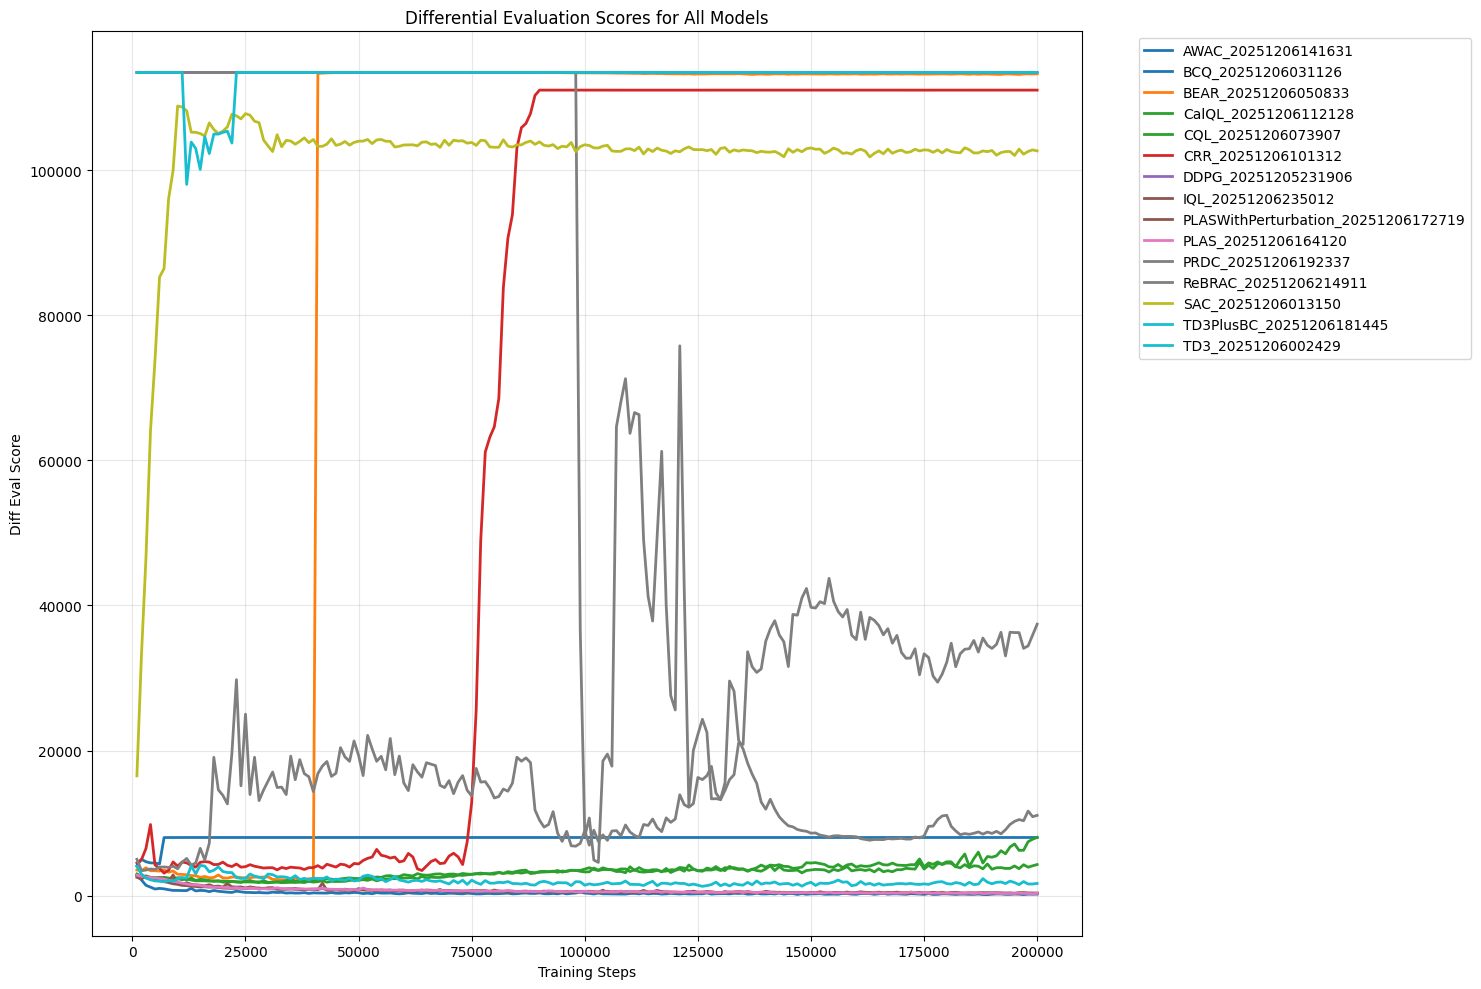

Plotted AWAC_20251206141631: 200 data points, final score: 8015.8
Plotted BCQ_20251206031126: 200 data points, final score: 214.0
Filtered out BEAR_20251206050833: final score 113282.0 > 10000
Plotted CalQL_20251206112128: 200 data points, final score: 8029.2
Plotted CQL_20251206073907: 200 data points, final score: 4284.0
Filtered out CRR_20251206101312: final score 111038.7 > 10000
Filtered out DDPG_20251205231906: final score 113474.3 > 10000
Plotted IQL_20251206235012: 200 data points, final score: 352.7
Plotted PLASWithPerturbation_20251206172719: 200 data points, final score: 325.8
Plotted PLAS_20251206164120: 200 data points, final score: 316.7
Filtered out PRDC_20251206192337: final score 37420.8 > 10000
Filtered out ReBRAC_20251206214911: final score 11068.0 > 10000
Filtered out SAC_20251206013150: final score 102659.5 > 10000
Plotted TD3PlusBC_20251206181445: 200 data points, final score: 1682.1
Filtered out TD3_20251206002429: final score 113474.3 > 10000


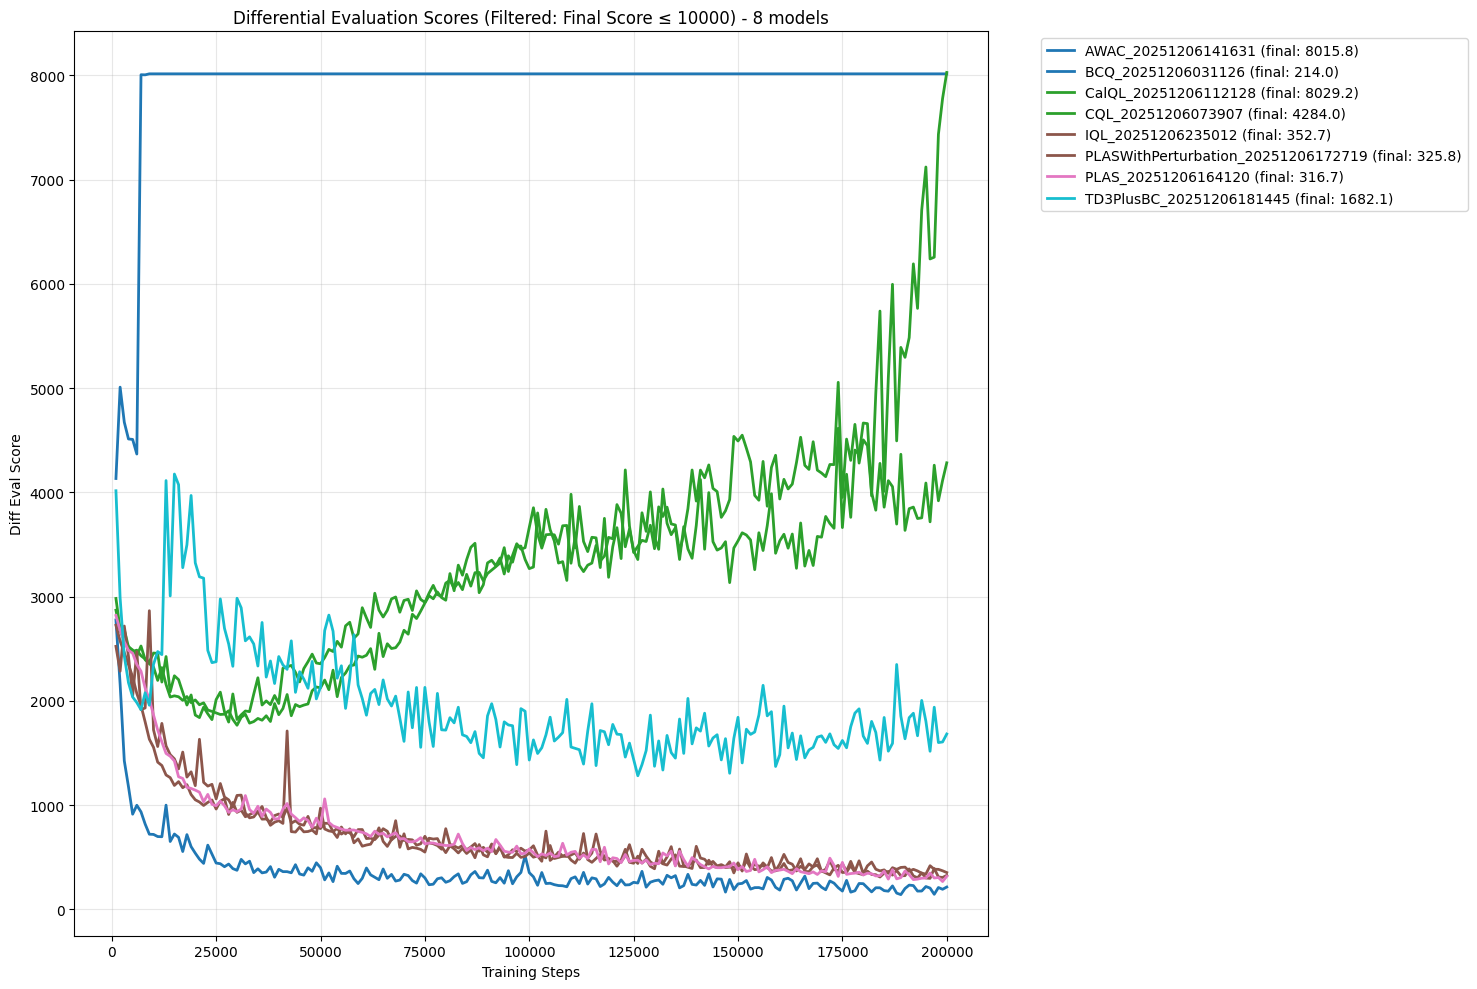

In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

# Function to plot diff_eval for all models
def plot_diff_eval_all_models():
    logs_dir = "logs/d3rlpy_logs"
    
    if not os.path.exists(logs_dir):
        print(f"Directory {logs_dir} not found!")
        return
    
    plt.figure(figsize=(15, 10))
    
    # Get all algorithm directories
    algorithm_dirs = [d for d in os.listdir(logs_dir) if os.path.isdir(os.path.join(logs_dir, d))]
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(algorithm_dirs)))
    
    for i, algorithm_name in enumerate(algorithm_dirs):
        algorithm_path = os.path.join(logs_dir, algorithm_name)
        diff_eval_path = os.path.join(algorithm_path, 'diff_eval.csv')
        
        if os.path.exists(diff_eval_path):
            try:
                # Read the CSV file
                df = pd.read_csv(diff_eval_path, header=None, names=['epoch', 'step', 'diff_eval'])
                
                # Plot the data
                plt.plot(df['step'], df['diff_eval'], 
                        label=algorithm_name, 
                        color=colors[i],
                        linewidth=2)
                
                print(f"Plotted {algorithm_name}: {len(df)} data points")
                
            except Exception as e:
                print(f"Error reading {diff_eval_path}: {e}")
        else:
            print(f"diff_eval.csv not found in {algorithm_path}")
    
    plt.title('Differential Evaluation Scores for All Models')
    plt.xlabel('Training Steps')
    plt.ylabel('Diff Eval Score')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Function to plot diff_eval for models with final score <= 10000
def plot_diff_eval_filtered_models():
    logs_dir = "logs/d3rlpy_logs"
    
    if not os.path.exists(logs_dir):
        print(f"Directory {logs_dir} not found!")
        return
    
    plt.figure(figsize=(15, 10))
    
    # Get all algorithm directories
    algorithm_dirs = [d for d in os.listdir(logs_dir) if os.path.isdir(os.path.join(logs_dir, d))]
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(algorithm_dirs)))
    filtered_count = 0
    
    for i, algorithm_name in enumerate(algorithm_dirs):
        algorithm_path = os.path.join(logs_dir, algorithm_name)
        diff_eval_path = os.path.join(algorithm_path, 'diff_eval.csv')
        
        if os.path.exists(diff_eval_path):
            try:
                # Read the CSV file
                df = pd.read_csv(diff_eval_path, header=None, names=['epoch', 'step', 'diff_eval'])
                
                # Check if final diff_eval value is <= 10000
                final_diff_eval = df['diff_eval'].iloc[-1]
                
                if final_diff_eval <= 10000:
                    # Plot the data
                    plt.plot(df['step'], df['diff_eval'], 
                            label=f"{algorithm_name} (final: {final_diff_eval:.1f})", 
                            color=colors[i],
                            linewidth=2)
                    
                    print(f"Plotted {algorithm_name}: {len(df)} data points, final score: {final_diff_eval:.1f}")
                    filtered_count += 1
                else:
                    print(f"Filtered out {algorithm_name}: final score {final_diff_eval:.1f} > 10000")
                
            except Exception as e:
                print(f"Error reading {diff_eval_path}: {e}")
        else:
            print(f"diff_eval.csv not found in {algorithm_path}")
    
    plt.title(f'Differential Evaluation Scores (Filtered: Final Score ≤ 10000) - {filtered_count} models')
    plt.xlabel('Training Steps')
    plt.ylabel('Diff Eval Score')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Execute both plotting functions
plot_diff_eval_all_models()
plot_diff_eval_filtered_models()